# <center> Image Classification </center>

## Importing the Dataset

In [1]:
#Importing os, glob and cv2 to read and import data
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import cv2
import glob

#Importing tqdm for the progress bar
from tqdm import tqdm

#Importing numpy and pandas for data manipulation
import numpy as np
import pandas as pd

#Import random for radomness
import random

#Importing matplotlib.pyplot for visual representation
import matplotlib.pyplot as plt

#Importing One Hot Encoder:
from sklearn.preprocessing import OneHotEncoder

#Importing train test split
from sklearn.model_selection import train_test_split

#Setting seed
seed = 5901

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-05-05 04:17:49.871636: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#Initializing the path of the datasets
trainPath = "/Users/sarathi/Desktop/plant-seedlings-classification-cs429529/train"
testPath = "/Users/sarathi/Desktop/plant-seedlings-classification-cs429529/test"

In [4]:
def loadData(path):
    X = []
    Y = []
    for y in os.listdir(path):
        if y != '.DS_Store':
            for img in glob.glob(path + "/" + y +"/*.png"):
                #reads the image as Blue-Green-Red
                image = cv2.imread(img)
                #converts the image to red-green-blue
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (224, 224))
                X.append(image)
                Y.append(y)
    return X, Y

In [5]:
X,Y = loadData(trainPath)

## Plotting the Data

In [6]:
def plotData(X, Y, col=4):
    label = set(Y)
    n = len(label)
    row = n // col
    if np.mod(n, col) != 0:
        row += 1
    fig, axs = plt.subplots(row, col, figsize=(10, 10))
    i = 0
    for y in label:
        index = random.choice(np.where(np.array(Y) == y)[0])
        axs[i // col, i % col].imshow(X[index])
        axs[i // col, i % col].axis("off")
        axs[i // col, i % col].set_title(y)
        i += 1
    for j in range(i, row * col):
        axs[j // col, j % col].axis("off")
    plt.show()

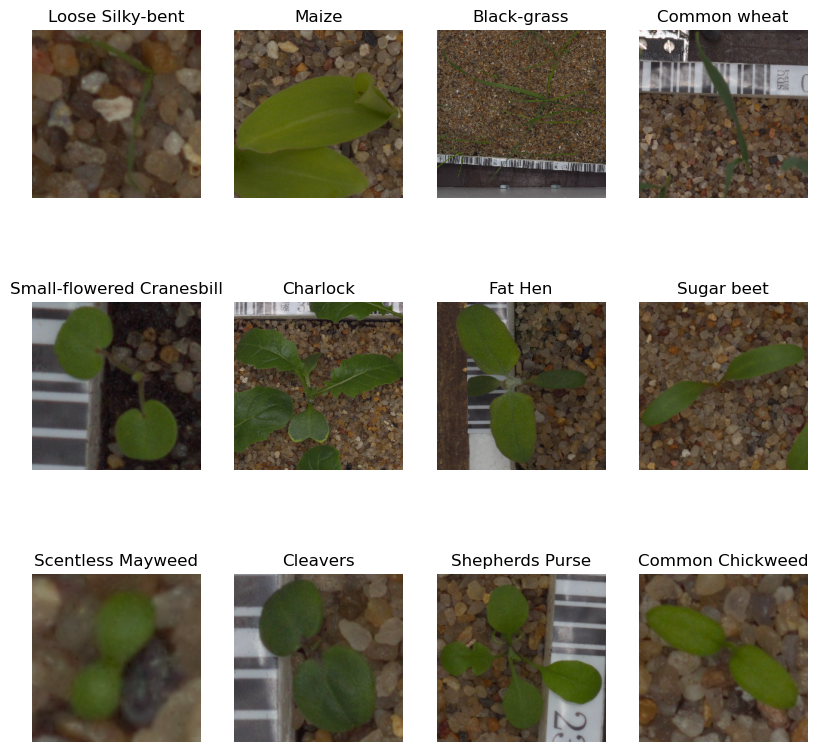

In [7]:
plotData(X, Y)

## Data Pre-Processing

In [8]:
#Perform Gaussian Blur to reduce Noise
def gaussianBlur(img):
    return cv2.GaussianBlur(img, (5,5), 0)

#Convert Image to HSV (Hue - Saturation - Value) to represent the color range better for masking
def HSV(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

#Creating boolean mask to segment the leaves in the image
def Mask(img):
    lGreen = (20, 40, 50)
    uGreen = (75, 255, 255)
    mask = cv2.inRange(img, lGreen, uGreen)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask > 0

def applyMask(img, showImg=False):
    
    gImg = gaussianBlur(img)
    hsvImg = HSV(gImg)
    amImg = np.zeros_like(img, np.uint8)
    mask = Mask(hsvImg)
    
    #Image Segmentation
    amImg[mask] = img[mask]
    
    if showImg:
        plt.subplot(2, 3, 1); plt.imshow(img); plt.title("Orginal Image")
        plt.subplot(2, 3, 2); plt.imshow(gImg); plt.title("Blur Image")
        plt.subplot(2, 3, 3); plt.imshow(hsvImg); plt.title("HSV Image")
        plt.subplot(2, 3, 4); plt.imshow(mask); plt.title("Mask")
        plt.subplot(2, 3, 5); plt.imshow(amImg); plt.title("Segmented Image")
    
    return amImg

#Normalizing the value to be between 0 to 1
def norm(data):
    return data/255

#One hot encoding the Class Values:
def oneHot(Y):
    Y = np.array(Y).reshape(-1, 1)
    encoder = OneHotEncoder()
    return encoder.fit_transform(Y), encoder

def decode(encoder, yPred):
    return np.array(encoder.categories_[0])[yPred]

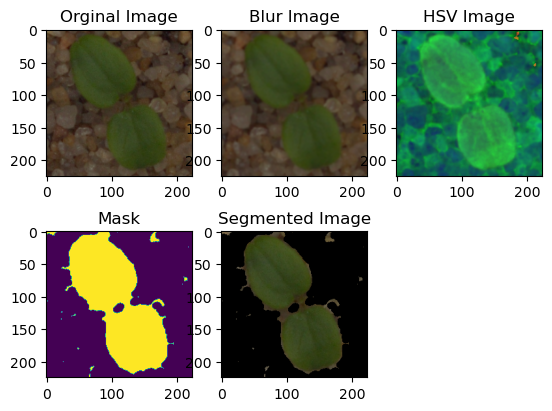

In [9]:
sample = applyMask(X[10], True)

In [10]:
def preprocessing(X, Y):
    ppX = []
    for img in X:
        ppX.append(applyMask(img))
    ppX = np.array(ppX)
    normX = norm(ppX)
    ohY, encoder = oneHot(Y)
    return normX, ohY.toarray(), encoder

In [11]:
ppX, ppY, encoder = preprocessing(X, Y)

## Checking for Class Imbalance

In [12]:
def classPlot(Y):
    pd.DataFrame(Y)[0].value_counts().plot(kind='bar')

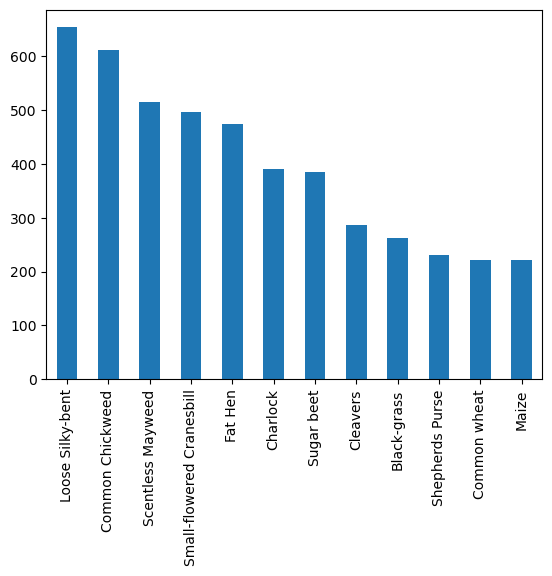

In [13]:
classPlot(Y)

## Training and Validation Split

In [14]:
trainX, valX, trainY, valY = train_test_split(ppX, ppY, test_size=0.2, stratify = ppY, shuffle=True)

In [15]:
datagen = ImageDataGenerator(
        rotation_range=180,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically 
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=True  # randomly flip images vertically
    )  
datagen.fit(trainX)

## Model

### MobileNetV2

In [16]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

In [17]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [18]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(12, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [19]:
for layer in base_model.layers:
    layer.trainable = False

In [20]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

history = model.fit(datagen.flow(trainX, trainY, batch_size=32, shuffle=True),
                    steps_per_epoch=len(trainX) // 32,
                    epochs=50,
                    validation_data=(valX, valY),
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1)

Epoch 1/50


2023-05-05 04:19:04.741837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


118/118 [==============================] - 111s 921ms/step - loss: 1.3283 - accuracy: 0.5587 - val_loss: 0.7425 - val_accuracy: 0.7484 - lr: 0.0010
Epoch 2/50
118/118 [==============================] - 127s 1s/step - loss: 0.8059 - accuracy: 0.7189 - val_loss: 0.6232 - val_accuracy: 0.7968 - lr: 0.0010
Epoch 3/50
118/118 [==============================] - 118s 995ms/step - loss: 0.6936 - accuracy: 0.7524 - val_loss: 0.5578 - val_accuracy: 0.8053 - lr: 0.0010
Epoch 4/50
118/118 [==============================] - 119s 1s/step - loss: 0.6739 - accuracy: 0.7588 - val_loss: 0.5993 - val_accuracy: 0.7832 - lr: 0.0010
Epoch 5/50
118/118 [==============================] - 138s 1s/step - loss: 0.6060 - accuracy: 0.7749 - val_loss: 0.4870 - val_accuracy: 0.8284 - lr: 0.0010
Epoch 6/50
118/118 [==============================] - 129s 1s/step - loss: 0.5678 - accuracy: 0.7903 - val_loss: 0.4747 - val_accuracy: 0.8326 - lr: 0.0010
Epoch 7/50
118/118 [==============================] - 121s 1s/step - 

## Evaluate

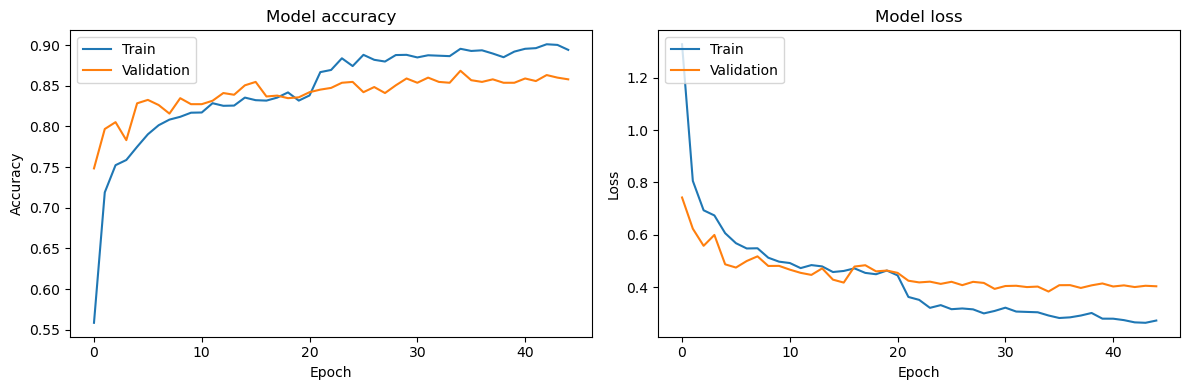

In [22]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [23]:
valLoss, valAcc = model.evaluate(valX, valY, verbose=2)

print(f'Test loss: {valLoss}')
print(f'Test accuracy: {valAcc}')

30/30 - 18s - loss: 0.4031 - accuracy: 0.8579 - 18s/epoch - 598ms/step
Test loss: 0.4030674397945404
Test accuracy: 0.8578947186470032


In [24]:
predV =  np.argmax(model.predict(valX), axis=1)

30/30 [==============================] - 19s 620ms/step


In [25]:
from sklearn.metrics import classification_report

valYC = decode(encoder, np.argmax(valY, axis=1))
predVC = decode(encoder, predV)

print(classification_report(valYC, predVC))

                           precision    recall  f1-score   support

              Black-grass       0.55      0.34      0.42        53
                 Charlock       0.95      0.96      0.96        78
                 Cleavers       0.92      0.93      0.92        58
         Common Chickweed       0.93      0.93      0.93       122
             Common wheat       0.70      0.73      0.71        44
                  Fat Hen       0.89      0.88      0.89        95
         Loose Silky-bent       0.76      0.82      0.79       131
                    Maize       0.89      0.91      0.90        44
        Scentless Mayweed       0.85      0.94      0.89       103
          Shepherds Purse       0.89      0.70      0.78        46
Small-flowered Cranesbill       0.98      0.93      0.95        99
               Sugar beet       0.80      0.90      0.85        77

                 accuracy                           0.86       950
                macro avg       0.84      0.83      0.83    

## Test

In [26]:
def loadTestData(path):
    X = []
    fName = []
    for img in glob.glob(path + "/*.png"):
        #reads the image as Blue-Green-Red
        image = cv2.imread(img)
        #converts the image to red-green-blue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        X.append(image)
        fName.append(img.split("/")[-1])
    return X, fName

In [27]:
testD, tName = loadTestData(testPath)

In [28]:
def preprocessingTest(X):
    ppX = []
    for img in X:
        ppX.append(applyMask(img))
    ppX = np.array(ppX)
    normX = norm(ppX)
    return normX

In [29]:
ppTD = preprocessingTest(testD)

In [30]:
yPred =  np.argmax(model.predict(ppTD), axis=1)

25/25 [==============================] - 15s 603ms/step


In [31]:
predictions = pd.DataFrame({
    "file": tName,
    "species": decode(encoder, yPred)
})

predictions.head()

,file,species
0,1b490196c.png,Shepherds Purse
1,85431c075.png,Loose Silky-bent
2,506347cfe.png,Common Chickweed
3,7f46a71db.png,Sugar beet
4,668c1007c.png,Charlock


In [32]:
predictions.to_csv("predicions.csv", index=False)